In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

## Small overlaps

In [10]:
# Conceptual visualization in 2D space

x_range = (-5, 5)
y_range = (-5, 5)
dx = np.linspace(*x_range, 100)
dy = np.linspace(*y_range, 100)


def sphere(x, y):
    return x ** 2 + y ** 2


def constraint(x, y, cx=3, cy=3):
    return (x - cx) ** 2 + (y - cy) ** 2


def upper_circle(x, cx=3, cy=3):
    val = np.maximum(3 - (x - cx) ** 2, 0)
    return cy + np.sqrt(val)


def lower_circle(x, cx=3, cy=3):
    val = np.maximum(3 - (x - cx) ** 2, 0)
    return cy - np.sqrt(val)


def plot_domain(ax: plt.Axes, cx=3, cy=3, legend=True, fontsize=18):
    # The whole domain [-5, 5] x [-5, 5] ==> mu([-5, 5] x [-5, 5]) = 100
    # The top γ (==> 0.1) quantile lies in the sphere
    # with the center at (0, 0) with the radius of √3
    # Let's say Γ ≒ 0.1 ==> center at (3, 3) with the radius of √3
    X, Y = np.meshgrid(dx, dy)
    Z = sphere(X, Y)
    level = np.linspace(Z.min(), Z.max(), 100)

    cont = ax.contourf(X, Y, Z, level)
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.fill_between(dx, upper_circle(dx, cx, cy), y_range[-1], color="gray", alpha=0.4, linewidth=0.0, label="Infeasible domain")
    ax.fill_between(dx, y_range[0], lower_circle(dx, cx, cy), color="gray", alpha=0.4, linewidth=0.0)
    ax.fill_between(dx, lower_circle(dx, 0, 0), upper_circle(dx, 0, 0), color="red", alpha=0.2, linewidth=0.0, label="top-10% domain")
    if legend:
        ax.legend(loc="upper left", fontsize=fontsize)

    return cont

In [11]:
import ConfigSpace as CS
from optimizer import TPEOptimizer
from util.utils import get_logger


def fetch_data(cx, cy, max_evals=100):
    def obj_func(eval_config, cx=3, cy=3):
        x = eval_config["x"]
        y = eval_config["y"]
        return {"loss": sphere(x, y), "constraint": constraint(x, y, cx, cy)}


    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameters([
        CS.UniformFloatHyperparameter("x", lower=x_range[0], upper=x_range[1]),
        CS.UniformFloatHyperparameter("y", lower=y_range[0], upper=y_range[1])   
    ])

    name = "small-overlap-ours"
    logger = get_logger(file_name=name, logger_name=name)
    kwargs = dict(
        obj_func=lambda eval_config: obj_func(eval_config, cx=cx, cy=cy),
        config_space=config_space,
        max_evals=max_evals,
        constraints={"constraint": 3.0},
        seed=0,
    )
    opt_ours = TPEOptimizer(
        **kwargs, resultfile=name,
    )
    opt_ours.optimize(logger)

    name = "small-overlap-naive"
    logger = get_logger(file_name=name, logger_name=name)
    opt_naive = TPEOptimizer(
        **kwargs, resultfile=name, naive_mode=True
    )
    opt_naive.optimize(logger)
    
    return opt_naive.fetch_observations(), opt_ours.fetch_observations()

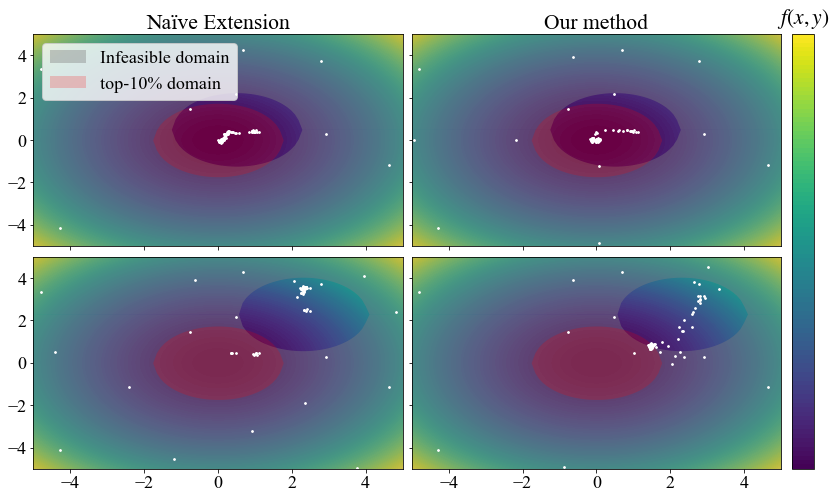

In [12]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(16, 8),
    gridspec_kw={"wspace": 0.025, "hspace": 0.05},
    sharey=True,
    sharex=True,
)

for r, center in enumerate([0.5, 2.3]):
    data_naive, data_ours = fetch_data(cx=center, cy=center, max_evals=100)
    legend = (r == 0)

    ax = axes[r][0]
    if r == 0:
        ax.set_title("Naïve Extension")

    plot_domain(ax, cx=center, cy=center, fontsize=18, legend=legend)
    ax.scatter(data_naive["x"], data_naive["y"], s=3, color="white")

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Our method")

    cont = plot_domain(ax, cx=center, cy=center, legend=False)
    ax.scatter(data_ours["x"], data_ours["y"], s=3, color="white")

cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), pad=0.0125)
cbar.ax.set_title("$f(x, y)$", y=1.01)
cbar.set_ticks([])
plt.savefig("small-overlap.pdf", bbox_inches='tight')

## Vanished constraints

In [13]:
# Conceptual visualization in 2D space

x_range = (-5, 5)
y_range = (-5, 5)
dx = np.linspace(*x_range, 100)
dy = np.linspace(*y_range, 100)
c_center, o_center = 1, -2


def sphere(x, y):
    return (x - o_center) ** 2 + (y - o_center) ** 2


def constraint(x, y):
    # radius 4: 16pi ~ 50%
    # radius 2: 4pi ~ 12.5%
    return (x - c_center) ** 2 + (y - c_center) ** 2


def upper_circle(x, cx, cy, rad):
    val = np.maximum(rad ** 2 - (x - cx) ** 2, 0)
    return cy + np.sqrt(val)


def lower_circle(x, cx, cy, rad):
    val = np.maximum(rad ** 2 - (x - cx) ** 2, 0)
    return cy - np.sqrt(val)


def compute_pi(opt: TPEOptimizer, X, Y):
    config_cands = [X.flatten(), Y.flatten()]
    pi = opt.tpe_samplers[opt.metric_name].compute_probability_improvement(
        config_cands
    )
    for obj_name in opt.constraints.keys():
        if opt.constraints[obj_name] == np.inf:
            continue

        pi += opt.tpe_samplers[obj_name].compute_probability_improvement(
            config_cands
        )

    return pi.reshape(X.shape)


def plot_domain(ax: plt.Axes, opt, rad, legend=True, fontsize=18):
    X, Y = np.meshgrid(dx, dy)
    Z = compute_pi(opt, X, Y)
    level = np.linspace(Z.min(), Z.max(), 100)

    sq3 = np.sqrt(3)
    cont = ax.contourf(X, Y, Z, level, cmap="rainbow")
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.fill_between(dx, upper_circle(dx, c_center, c_center, rad), y_range[-1], color="gray", alpha=0.4, linewidth=0.0, label="Infeasible domain")
    ax.fill_between(dx, y_range[0], lower_circle(dx, c_center, c_center, rad), color="gray", alpha=0.4, linewidth=0.0)
    ax.fill_between(dx, lower_circle(dx, o_center, o_center, sq3), upper_circle(dx, o_center, o_center, sq3), color="red", alpha=0.2, linewidth=0.0, label="top-10% domain")
    if legend:
        ax.legend(loc="upper left", fontsize=fontsize)

    return cont

In [14]:
def fetch_opt(rad, max_evals=100, seed=0):
    def obj_func(eval_config):
        x = eval_config["x"]
        y = eval_config["y"]
        return {"loss": sphere(x, y), "constraint": constraint(x, y)}


    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameters([
        CS.UniformFloatHyperparameter("x", lower=x_range[0], upper=x_range[1]),
        CS.UniformFloatHyperparameter("y", lower=y_range[0], upper=y_range[1])   
    ])

    name = "vanished-constraint-ours"
    logger = get_logger(file_name=name, logger_name=name)
    kwargs = dict(
        obj_func=obj_func,
        config_space=config_space,
        max_evals=max_evals,
        n_init=max_evals,
        constraints={"constraint": rad ** 2},
        seed=seed,
    )
    opt_ours = TPEOptimizer(
        **kwargs, resultfile=name,
    )
    opt_ours.optimize(logger)

    name = "vanished-constraint-naive"
    logger = get_logger(file_name=name, logger_name=name)
    opt_naive = TPEOptimizer(
        **kwargs, resultfile=name, naive_mode=True
    )
    opt_naive.optimize(logger)
    
    return opt_naive, opt_ours

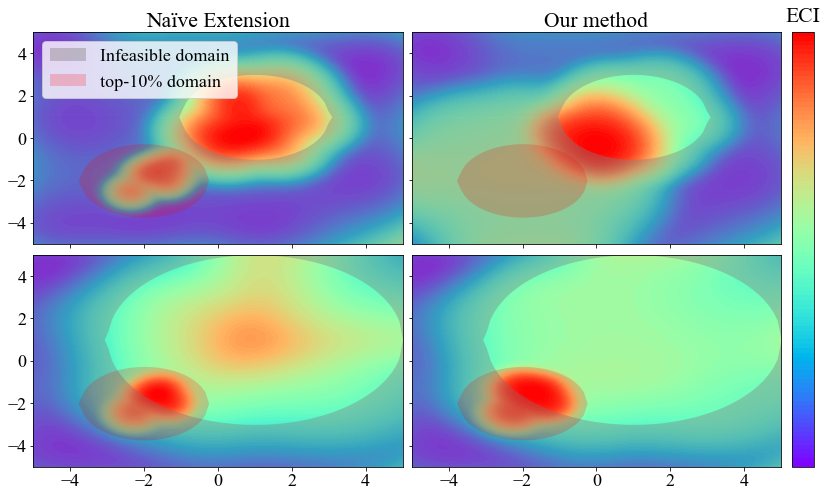

In [15]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(16, 8),
    gridspec_kw={"wspace": 0.025, "hspace": 0.05},
    sharey=True,
    sharex=True,
)

for r, rad in enumerate([2, 4]):
    opt_naive, opt_ours = fetch_opt(rad, max_evals=200, seed=42)
    legend = (r == 0)

    ax = axes[r][0]
    if r == 0:
        ax.set_title("Naïve Extension")

    plot_domain(ax, opt=opt_naive, rad=rad, fontsize=18, legend=legend)

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Our method")

    cont = plot_domain(ax, opt=opt_ours, rad=rad, legend=False)


cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), pad=0.0125)
cbar.ax.set_title("ECI", y=1.01)
cbar.set_ticks([])
plt.savefig("vanished-constraint.pdf", bbox_inches='tight')